# Document aligner project
## NEW Model Implementation
- U-Net with skip connections
- Flow predictor, differentiable warping
- Standard encoder-decoder

In [7]:
from dataset_loader import get_dataloaders, visualize_batch
from reconstruction_model import ResNetUnet
from reconstruction_model import MaskedL1Loss, MaskedMSELoss, SSIMLoss, UVReconstructionLoss
from training_val import train_one_epoch, validate

import time 
import os
import glob
from typing import Dict, List, Tuple, Optional, Callable
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np


In [8]:
# Create dataloaders
train_loader, val_loader = get_dataloaders(
    data_dir='/home/daniel-choate/Datasets/DocUnwarp/renders/synthetic_data_pitch_sweep',
    batch_size=8,
    train_split=0.8,
    img_size=(512, 512), #(256, 256)
)

# Visualize samples
sample_batch = next(iter(train_loader))
# visualize_batch(sample_batch, num_samples=4)

Found 2486 samples in /home/daniel-choate/Datasets/DocUnwarp/renders/synthetic_data_pitch_sweep
Train samples: 1988, Val samples: 498


# Model description
- TODO

Training:
- [x] Additional metrics (PSNR, SSIM)
- [x] Learning rate scheduling
- [ ] Gradient clipping
- [ ] Mixed precision training
- [ ] Logging to tensorboard/wandb

Main training loop
- [x] Implement better model architecture
- [x] Try different loss functions
- [x] Add learning rate scheduling
- [ ] Implement early stopping
- [ ] Add visualization and logging
- [ ] Experiment with data augmentation
- [ ] Use pretrained model from HuggingFace
- [ ] Enable MASKED LOSSES
- [ ] Use DEPTH
- [x] Use UV
- [x] Use BORDER
- [x] Try different OPTIMIZERS

## Training Loop

In [9]:
# Main training loop 

def main():
    """
    Main training loop 

    *** CHECK TODO LIST ***

    """
    
    # Configuration
    DATA_DIR = '/home/daniel-choate/Datasets/DocUnwarp/renders/synthetic_data_pitch_sweep'
    BATCH_SIZE = 8
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    IMG_SIZE = (256, 256) # (512, 512) Using smaller images for faster training for now

    # Set device 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create dataloaders
    train_loader, val_loader = get_dataloaders(
        data_dir=DATA_DIR,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        use_depth=False, # TODO: True if using depth info
        use_uv=True, # TODO: True if using UV maps
        use_border=True # TODO: True if using border masks for better training
    )

    # Visualize a batch (testing)
    sample_batch = next(iter(train_loader))
    print(f"Batch RGB shape: {sample_batch['rgb'].shape}")
    print(f"Batch GT shape: {sample_batch['ground_truth'].shape}")
    if 'border' in sample_batch:
        print(f"Batch border mask shape: {sample_batch['border'].shape}")
    if 'uv' in sample_batch:
        print(f"Batch UV shape: {sample_batch['uv'].shape}")
    # visualize_batch(sample_batch)  # Optional visualization


    # Create model
    # model = DocumentReconstructionModel().to(device)
    model = ResNetUnet(
        backbone_name='resnet34',
        pretrained=True
    ).to(device)
    print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

    # TODO: TRY DIFFERENT LOSS FUNCTIONS
    # Option 1: simple losses (baseline, just to get it working)
    # criterion = nn.MSELoss() # Basic L2 Loss - sensitive to lighting
    # criterion = nn.L1Loss() # L1 loss also sensitive to lighting

    # Option 2: SSIM loss (RECOMMENDED - structure instead of lighting)
    # criterion = SSIMLoss() # Might need a pip install

    # Option 3: Masked losses (doc pixel focus)
    # Make sure to do use_border = True above **
    # criterion = MaskedL1Loss(use_mask=True)
    # criterion = MaskedMSELoss(use_mask=True)

    # Option 4: Combined loss with UV supervision (GET TO THIS EVENTUALLY)
    # NOTE: need to set use_uv = True, use_border = True, 
    criterion = UVReconstructionLoss(
        reconstruction_weight=1.0,
        uv_weight=0.5,
        smoothness_weight=0.01, 
        use_mask=True,
        loss_type='ssim' # Use SSIM for geometric recon
    )

    # TODO: TRY DIFFERENT OPTIMIZERS
    # optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        # Epoch timing check
        start_epoch = time.time()
        
        print(f"\n{'='*50}")
        print(f"EPOCH {epoch+1}/{NUM_EPOCHS}")
        print(f"{'='*50}")

        # TRAIN 
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
        print(f"Train loss: {train_loss:.4f}")
        train_losses.append(train_loss)

        # VALIDATE 
        val_loss = validate(model, val_loader, criterion, device)
        print(f"Val Loss: {val_loss:.4f}")
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, 'training_history.pth')

        # Save the best model 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved best model with val loss {val_loss:.4f}")

        epoch_time = time.time() - start_epoch
        print(f"Epoch time: {epoch_time:.4f}s")

    print("\nTraining complete!")
    print(f"Best validation loss: {best_val_loss:.4f}")


    # Loss curve 
    epochs = range(1, NUM_EPOCHS + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    

In [4]:
# Execute main 

print("Document Reconstruction Dataset Loader")
print("="*50)

# Quick test 
train_loader, val_loader = get_dataloaders(
    data_dir = '/home/daniel-choate/Datasets/DocUnwarp/renders/synthetic_data_pitch_sweep',
    batch_size = 4, 
    img_size=(256, 256) # (512,512)
)

print("\nDataset loaded successfully!")

# # Visualize sample batch 
# print("\nVisualizing a sample batch ...")
# sample_batch = next(iter(train_loader))
# print(f"Batch shape - RGB: {sample_batch['rgb'].shape}, Ground Truth: {sample_batch['ground_truth'].shape}")
# visualize_batch(sample_batch, num_samples=min(4, sample_batch['rgb'].shape[0]))

# Main training loop 
main()

Document Reconstruction Dataset Loader
Found 2486 samples in /home/daniel-choate/Datasets/DocUnwarp/renders/synthetic_data_pitch_sweep
Train samples: 1988, Val samples: 498

Dataset loaded successfully!
Using device: cuda
Found 2486 samples in /home/daniel-choate/Datasets/DocUnwarp/renders/synthetic_data_pitch_sweep
Train samples: 1988, Val samples: 498
Batch RGB shape: torch.Size([8, 3, 256, 256])
Batch GT shape: torch.Size([8, 3, 256, 256])
Batch border mask shape: torch.Size([8, 1, 256, 256])
Batch UV shape: torch.Size([8, 3, 256, 256])

Model parameters: 24,298,884

EPOCH 1/50
Train loss: 1.2126
Val Loss: 1.0953
Saved best model with val loss 1.0953
Epoch time: 166.5393s

EPOCH 2/50
Train loss: 1.0680
Val Loss: 1.0425
Saved best model with val loss 1.0425
Epoch time: 167.5080s

EPOCH 3/50
Train loss: 1.0243
Val Loss: 1.0047
Saved best model with val loss 1.0047
Epoch time: 168.0900s

EPOCH 4/50
Train loss: 1.0005
Val Loss: 0.9943
Saved best model with val loss 0.9943
Epoch time: 16

NameError: name 'plt' is not defined

/tmp/ipykernel_45912/1633552597.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load('training_history.pth')


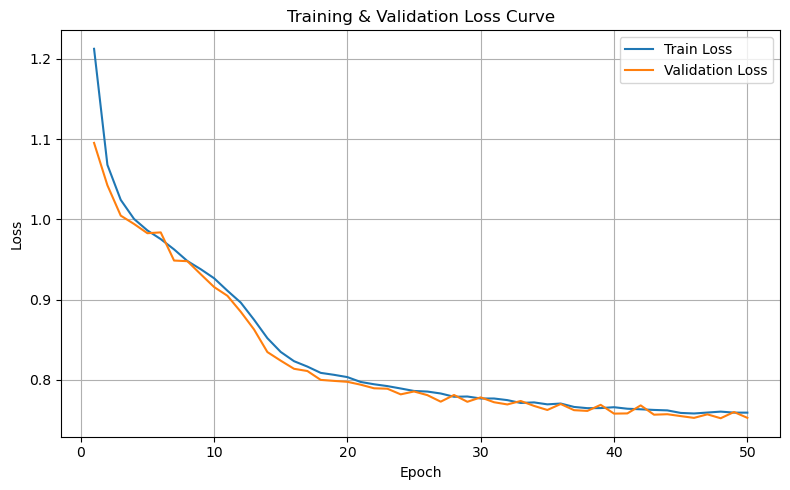

In [6]:
# Loss plot 
import matplotlib.pyplot as plt

history = torch.load('training_history.pth')

train_losses = history['train_losses']
val_losses = history['val_losses']
epochs = range(1, 50 + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()